In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

class CursedorBlessed():
    IMG_SIZE = 256
    CURSE = "data/cursed"
    BLESS = "data/blessed"
    LABELS = {CURSE:0, BLESS:1}
    training_data = [] # Added to this data later on
    cursecount = 0 # Balance between the data
    blesscount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # Color is not a relavant feature to determine
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) # numpy.eye creates 1 vector

                    if label == self.CURSE:
                        self.cursecount += 1
                    elif label == self.BLESS:
                        self.blesscount += 1
                except Exception as e:
                    pass # Skip images that can't be loaded for whatever strange reason
                
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Curse count: ", self.cursecount)
        print("Bless count: ", self.blesscount)
        
curseorbless = CursedorBlessed()
curseorbless.make_training_data()

100%|██████████| 1212/1212 [00:17<00:00, 71.17it/s]


Curse count:  1219
Bless count:  1212


In [2]:
# Load the training data
training_data = np.load("training_data.npy", allow_pickle = True) # Pickle is a security thing to prevent code execution
print(len(training_data))

2431


[1. 0.]


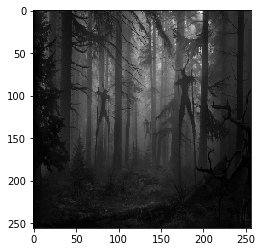

In [4]:
import matplotlib.pyplot as plt # Show a sample data and see it's been loaded successfully
plt.imshow(training_data[0][0], cmap = "gray")
print(training_data[0][1]) # Classification of cursed or blessed
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0")

X = torch.Tensor([i[0] for i in training_data]).view(-1,256,256)
X = X / 255.0 # Scaling the imagery to between 0 and 1
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 # 10% of data
val_size = int(len(X) * VAL_PCT)
print(val_size)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 16) # Input 1, 32 features, 5 kernels to find features
        self.conv2 = nn.Conv2d(32, 64, 16)
        self.conv3 = nn.Conv2d(64, 128, 16)
        # Convolutional layers needs to go to linear layers eventually
        
        # We need to pass some fake data to figure out the convnet output neurons
        x = torch.randn(256,256).view(-1,1,256,256) # Positive 1 is related to the first 1, -1 means whatever feature set amount
        self._to_linear = None
        
        self.convs(x) # Sets self._to_linear
        
        self.fc1 = nn.Linear(self._to_linear, 512)

        self.fc2 = nn.Linear(512, 256)
        
        self.fc3 = nn.Linear(256, 2) # Output to cursed or blessed
    
    # Calculate output size of the last convolutional layer
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (3,3)) # Shape of pooling will be 3 by 3
        x = F.max_pool2d(F.relu(self.conv2(x)), (3,3))
        x = F.max_pool2d(F.relu(self.conv3(x)), (3,3))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim = 1) # Dimension is 1 due to batches
        
    
net = Net().to(device)

243


In [6]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

2188
243


In [36]:
BATCH_SIZE = 200 # If you run out of vram lower this value
EPOCHS = 20

def train(net):
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
    loss_function = nn.MSELoss()
    for epoch in range(EPOCHS):
        for i in tqdm(range(0,len(train_X), BATCH_SIZE)): # Range from 0, things in X, steps in BATCH_SIZE
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,256,256)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            loss_function.zero_grad()
            outputs = net(batch_X)
            
            matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
            in_sample_acc = matches.count(True)/len(matches)
            
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
    print(loss)
    print("In-sample accuracy: ", round(in_sample_acc, 2))

In [37]:
def test():
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1,1,256,256).to(device))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1

    print("Accuracy: ", round(correct/total, 3))

In [38]:
train(net)

100%|██████████| 11/11 [00:02<00:00,  4.89it/s]

tensor(0.2312, device='cuda:0', grad_fn=<MseLossBackward>)
In-sample accuracy:  0.63


In [39]:
test()

100%|██████████| 243/243 [00:00<00:00, 374.96it/s]

Accuracy:  0.506


In [40]:
def testCurse(num):
    if torch.argmax(net(test_X[num].view(-1,1,256,256).to(device))[0]):
        print("Predicted: Blessed")
    else:
        print("Predicted: Cursed")

    if torch.argmax(test_y[num]):
        print("Actual: Blessed")
    else:
        print("Actual: Cursed")
    plt.imshow(test_X[num], cmap = "gray")
    plt.show()

    output = net(test_X[num].view(-1,1,256,256).to(device))[0]
    cursed = float(output[0])
    blessed = float(output[1])

    print(str(cursed) + "% cursed and " + str(blessed) + "% blessed")
    print("")


In [44]:
torch.save(net, "model_final_256_256")

Predicted: Blessed
Actual: Cursed


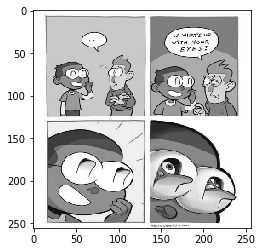

0.46695631742477417% cursed and 0.5330436825752258% blessed

Predicted: Blessed
Actual: Blessed


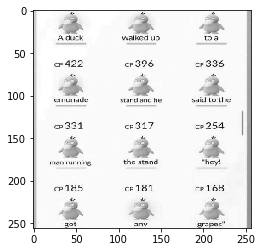

0.4743502140045166% cursed and 0.5256498456001282% blessed

Predicted: Blessed
Actual: Blessed


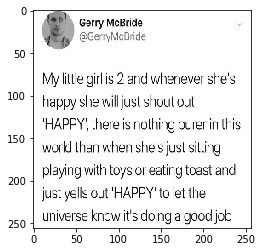

0.45989498496055603% cursed and 0.5401049852371216% blessed

Predicted: Cursed
Actual: Cursed


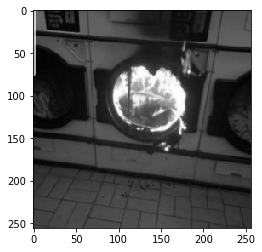

0.5483513474464417% cursed and 0.45164865255355835% blessed

Predicted: Cursed
Actual: Cursed


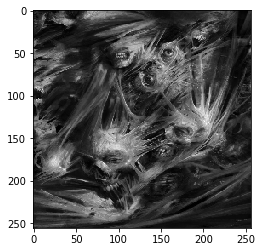

0.5542563199996948% cursed and 0.4457436800003052% blessed



In [45]:
for i in range(5):
    testCurse(i)